In [5]:
from dotenv import load_dotenv 
load_dotenv('../.env')

import pandas as pd 
from langchain.schema import Document
from langchain_text_splitters import RecursiveCharacterTextSplitter, CharacterTextSplitter
import yaml
import driver.weaviatedb as weaviatedb
import uuid
import os
from typing import Dict, List, Any, Optional
import re
from tqdm import tqdm

from langchain_openai import ChatOpenAI, OpenAI
from langchain_community.llms import Ollama
from langchain_community.chat_models import ChatOllama
from langchain.chains import LLMChain, ConversationalRetrievalChain
from langchain.chains.combine_documents.stuff import StuffDocumentsChain
from langchain.memory import ConversationBufferMemory
from langchain_core.runnables.history import RunnableWithMessageHistory
from langchain_openai import OpenAIEmbeddings
from langchain_community.embeddings import OllamaEmbeddings
from driver import redisdb, weaviatedb
from service.langchainbot import LangChainBot
import warnings; warnings.simplefilter('ignore')



# About Dataset

The file data/recipes.csv contains information on over 1000 recipes, including recipe names, preparation times, cooking times, ratings, ingredient lists, and step-by-step directions

In this project, I just use for 100 recipes.

- recipe_name: The name of the recipe. (String)
- prep_time: The amount of time required to prepare the recipe. (Integer)
- cook_time: The amount of time required to cook the recipe. (Integer)
- total_time: The total amount of time required to prepare and cook the recipe. (Integer)
- servings: The number of servings the recipe yields. (Integer)
- ingredients: A list of ingredients required to make the recipe. (List)
- directions: A list of directions for preparing and cooking the recipe. (List)
- rating: The recipe rating. (Float)
- url: The recipe URL. (String)
- cuisine_path: The recipe cuisine path. (String)
- nutrition: The recipe nutrition information. (Dictionary)
- timing: The recipe timing information. (Dictionary)
- img_src: Links to the image of the recipe

This dataset from Kaggle: [Recipes Dataset](https://www.kaggle.com/datasets/thedevastator/better-recipes-for-a-better-life)


# Data Processing

In [2]:
path = "/home/kdts34/LLM/cuonghv/Recipe_Assistance/data/recipes.csv" 
df = pd.read_csv(path)
df.head()

,Unnamed: 0,recipe_name,prep_time,cook_time,total_time,servings,yield,ingredients,directions,rating,url,cuisine_path,nutrition,timing,img_src
0,0,Apple-Cranberry Crostada,NaN,NaN,NaN,8,6 to 8 - servings,"3 tablespoons butter, 2 pounds Granny Smith ap...",Heat butter in a large skillet over medium-hig...,4.4,https://www.allrecipes.com/recipe/76931/apple-...,/Desserts/Fruit Desserts/Apple Dessert Recipes/,"Total Fat 18g 23%, Saturated Fat 7g 34%, Chole...","Servings: 8, Yield: 6 to 8 - servings",https://www.allrecipes.com/thmb/Tf1wH73bfH6Oql...
1,1,Apple Pie by Grandma Ople,30 mins,1 hrs,1 hrs 30 mins,8,1 9-inch pie,"8 small Granny Smith apples, or as needed, ½ c...","Peel and core apples, then thinly slice. Set a...",4.8,https://www.allrecipes.com/recipe/12682/apple-...,/Desserts/Pies/Apple Pie Recipes/,"Total Fat 19g 24%, Saturated Fat 9g 46%, Chole...","Prep Time: 30 mins, Cook Time: 1 hrs, Total Ti...",https://www.allrecipes.com/thmb/1I95oiTGz6aEpu...
2,2,Sarah's Homemade Applesauce,10 mins,15 mins,25 mins,4,NaN,"4 apples - peeled, cored and chopped, ¾ cup w...","Combine apples, water, sugar, and cinnamon in ...",4.8,https://www.allrecipes.com/recipe/51301/sarahs...,/Side Dish/Applesauce Recipes/,"Total Fat 0g 0%, Sodium 3mg 0%, Total Carbohyd...","Prep Time: 10 mins, Cook Time: 15 mins, Total ...",https://www.allrecipes.com/thmb/VY5d0tZHB8xz6y...
3,3,Apple Crisp,30 mins,45 mins,1 hrs 15 mins,12,1 9x13-inch pan,"10 cups all-purpose apples, peeled, cored and ...",Preheat the oven to 350 degrees F (175 degrees...,4.7,https://www.allrecipes.com/recipe/12409/apple-...,/Desserts/Crisps and Crumbles Recipes/Apple Cr...,"Total Fat 8g 11%, Saturated Fat 5g 25%, Choles...","Prep Time: 30 mins, Cook Time: 45 mins, Total ...",https://www.allrecipes.com/thmb/uAzhPOh86PfR-N...
4,4,Apple Pie Filling,20 mins,20 mins,2 hrs 40 mins,40,5 9-inch pies,"18 cups thinly sliced apples, 3 tablespoons le...",Toss apples with lemon juice in a large bowl a...,4.7,https://www.allrecipes.com/recipe/12681/apple-...,/Desserts/Pies/Apple Pie Recipes/,"Total Fat 0g 0%, Sodium 61mg 3%, Total Carbohy...","Prep Time: 20 mins, Cook Time: 20 mins, Additi...",https://www.allrecipes.com/thmb/c0bbYaS1V_mTt_...


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1090 entries, 0 to 1089
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Unnamed: 0    1090 non-null   int64  
 1   recipe_name   1090 non-null   object 
 2   prep_time     1039 non-null   object 
 3   cook_time     782 non-null    object 
 4   total_time    1045 non-null   object 
 5   servings      1090 non-null   int64  
 6   yield         879 non-null    object 
 7   ingredients   1090 non-null   object 
 8   directions    1090 non-null   object 
 9   rating        1090 non-null   float64
 10  url           1090 non-null   object 
 11  cuisine_path  1090 non-null   object 
 12  nutrition     1090 non-null   object 
 13  timing        1090 non-null   object 
 14  img_src       1090 non-null   object 
dtypes: float64(1), int64(2), object(12)
memory usage: 127.9+ KB


In [4]:
def preprocess_text(text):
    """
    Clean text by removing leading/trailing whitespace, 
    Reducing multiple spaces and newlines.
    """
    return re.sub(r' +', ' ', re.sub(r'\n+', '\n', text.strip()))

def clean_dataframe(df):
    """Clean DataFrame by removing NaN rows and processing the 'directions' column."""
    df_cleaned = df.dropna().reset_index(drop=True)
    df_cleaned['directions'] = df_cleaned['directions'].apply(preprocess_text)
    return df_cleaned

In [5]:
# remove nan rows
cleaned_data = clean_dataframe(df)
cleaned_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 631 entries, 0 to 630
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Unnamed: 0    631 non-null    int64  
 1   recipe_name   631 non-null    object 
 2   prep_time     631 non-null    object 
 3   cook_time     631 non-null    object 
 4   total_time    631 non-null    object 
 5   servings      631 non-null    int64  
 6   yield         631 non-null    object 
 7   ingredients   631 non-null    object 
 8   directions    631 non-null    object 
 9   rating        631 non-null    float64
 10  url           631 non-null    object 
 11  cuisine_path  631 non-null    object 
 12  nutrition     631 non-null    object 
 13  timing        631 non-null    object 
 14  img_src       631 non-null    object 
dtypes: float64(1), int64(2), object(12)
memory usage: 74.1+ KB


In [6]:
# Just collect 100 rows from cleaned data
data = cleaned_data[:100]

In [7]:
data.head()

,Unnamed: 0,recipe_name,prep_time,cook_time,total_time,servings,yield,ingredients,directions,rating,url,cuisine_path,nutrition,timing,img_src
0,1,Apple Pie by Grandma Ople,30 mins,1 hrs,1 hrs 30 mins,8,1 9-inch pie,"8 small Granny Smith apples, or as needed, ½ c...","Peel and core apples, then thinly slice. Set a...",4.8,https://www.allrecipes.com/recipe/12682/apple-...,/Desserts/Pies/Apple Pie Recipes/,"Total Fat 19g 24%, Saturated Fat 9g 46%, Chole...","Prep Time: 30 mins, Cook Time: 1 hrs, Total Ti...",https://www.allrecipes.com/thmb/1I95oiTGz6aEpu...
1,3,Apple Crisp,30 mins,45 mins,1 hrs 15 mins,12,1 9x13-inch pan,"10 cups all-purpose apples, peeled, cored and ...",Preheat the oven to 350 degrees F (175 degrees...,4.7,https://www.allrecipes.com/recipe/12409/apple-...,/Desserts/Crisps and Crumbles Recipes/Apple Cr...,"Total Fat 8g 11%, Saturated Fat 5g 25%, Choles...","Prep Time: 30 mins, Cook Time: 45 mins, Total ...",https://www.allrecipes.com/thmb/uAzhPOh86PfR-N...
2,4,Apple Pie Filling,20 mins,20 mins,2 hrs 40 mins,40,5 9-inch pies,"18 cups thinly sliced apples, 3 tablespoons le...",Toss apples with lemon juice in a large bowl a...,4.7,https://www.allrecipes.com/recipe/12681/apple-...,/Desserts/Pies/Apple Pie Recipes/,"Total Fat 0g 0%, Sodium 61mg 3%, Total Carbohy...","Prep Time: 20 mins, Cook Time: 20 mins, Additi...",https://www.allrecipes.com/thmb/c0bbYaS1V_mTt_...
3,7,Apple-Cranberry Crisp,25 mins,40 mins,1 hrs 5 mins,8,1 8-inch crisp,"2 pounds Granny Smith apples - peeled, cored a...",Preheat the oven to 375 degrees F (190 degrees...,4.6,https://www.allrecipes.com/recipe/41893/apple-...,/Desserts/Crisps and Crumbles Recipes/,"Total Fat 12g 15%, Saturated Fat 4g 22%, Chole...","Prep Time: 25 mins, Cook Time: 40 mins, Total ...",https://www.allrecipes.com/thmb/MjDDFmBWiEx9f1...
4,10,Apple Turnovers,30 mins,25 mins,55 mins,8,8 turnovers,"2 tablespoons lemon juice, 4 cups water, 4 Gr...",Combine the lemon and 4 cups water in a large ...,4.6,https://www.allrecipes.com/recipe/59124/apple-...,/Desserts/Fruit Desserts/Apple Dessert Recipes/,"Total Fat 26g 33%, Saturated Fat 8g 39%, Chole...","Prep Time: 30 mins, Cook Time: 25 mins, Total ...",https://www.allrecipes.com/thmb/6EpK8eOrDHd4MM...


In [8]:
print(data['directions'][0])

Peel and core apples, then thinly slice. Set aside.
Preheat the oven to 425 degrees F (220 degrees C).
Melt butter in a saucepan over medium heat. Add flour and stir to form a paste; cook until fragrant, about 1 to 2 minutes. Add both sugars and water; bring to a boil. Reduce the heat to low and simmer for 3 to 5 minutes. Remove from the heat.
Press one pastry into the bottom and up the sides of a 9-inch pie pan. Roll out remaining pastry so it will overhang the pie by about 1/2 inch. Cut pastry into eight 1-inch strips.
Place sliced apples into the bottom crust, forming a slight mound. Lay four pastry strips vertically and evenly spaced over apples, using longer strips in the center and shorter strips at the edges.
Make a lattice crust: Fold the first and third strips all the way back so they're almost falling off the pie. Lay one of the unused strips perpendicularly over the second and fourth strips, then unfold the first and third strips back into their original position.
Fold the s

In [9]:
# Testing function creating the processed data
for i, row in data.iterrows():
    context_columns = ['recipe_name', 'directions', 'prep_time', 'cook_time', 'servings', 'ingredients']
    # recipe_info = f"\n recipe_name: {row['recipe_name']} \n directions: {row['directions']} \n prep_time: {row['prep_time']} \n cook_time: {row['cook_time']} servings: {row['servings']} \n ingredients: {row['ingredients']}"
    context = [f'\n {column}: {row[column]}' for column in context_columns]
    recipe_info = " ".join(context)
    print(f'{i}: {recipe_info}')
    if i == 3:
        break 

0: 
 recipe_name: Apple Pie by Grandma Ople 
 directions: Peel and core apples, then thinly slice. Set aside.
Preheat the oven to 425 degrees F (220 degrees C).
Melt butter in a saucepan over medium heat. Add flour and stir to form a paste; cook until fragrant, about 1 to 2 minutes. Add both sugars and water; bring to a boil. Reduce the heat to low and simmer for 3 to 5 minutes. Remove from the heat.
Press one pastry into the bottom and up the sides of a 9-inch pie pan. Roll out remaining pastry so it will overhang the pie by about 1/2 inch. Cut pastry into eight 1-inch strips.
Place sliced apples into the bottom crust, forming a slight mound. Lay four pastry strips vertically and evenly spaced over apples, using longer strips in the center and shorter strips at the edges.
Make a lattice crust: Fold the first and third strips all the way back so they're almost falling off the pie. Lay one of the unused strips perpendicularly over the second and fourth strips, then unfold the first and 

In [10]:
# Creating processed data
processed_data = pd.DataFrame([])
documents = []
for i, row in data.iterrows():
    context_columns = ['recipe_name', 'directions', 'prep_time', 'cook_time', 'servings', 'ingredients']
    context = [f'\n {column}: {row[column]}' for column in context_columns]
    recipe_info = " ".join(context)
    documents.append(recipe_info)
processed_data['Document'] = documents
processed_data['Url'] = data['url']
processed_data['Text_Length'] = processed_data['Document'].apply(lambda x: len(x.split(' ')))
processed_data.head()

,Document,Url,Text_Length
0,\n recipe_name: Apple Pie by Grandma Ople \n d...,https://www.allrecipes.com/recipe/12682/apple-...,346
1,\n recipe_name: Apple Crisp \n directions: Pre...,https://www.allrecipes.com/recipe/12409/apple-...,153
2,\n recipe_name: Apple Pie Filling \n direction...,https://www.allrecipes.com/recipe/12681/apple-...,152
3,\n recipe_name: Apple-Cranberry Crisp \n direc...,https://www.allrecipes.com/recipe/41893/apple-...,131
4,\n recipe_name: Apple Turnovers \n directions:...,https://www.allrecipes.com/recipe/59124/apple-...,288


In [11]:
print(processed_data['Document'][0])


 recipe_name: Apple Pie by Grandma Ople 
 directions: Peel and core apples, then thinly slice. Set aside.
Preheat the oven to 425 degrees F (220 degrees C).
Melt butter in a saucepan over medium heat. Add flour and stir to form a paste; cook until fragrant, about 1 to 2 minutes. Add both sugars and water; bring to a boil. Reduce the heat to low and simmer for 3 to 5 minutes. Remove from the heat.
Press one pastry into the bottom and up the sides of a 9-inch pie pan. Roll out remaining pastry so it will overhang the pie by about 1/2 inch. Cut pastry into eight 1-inch strips.
Place sliced apples into the bottom crust, forming a slight mound. Lay four pastry strips vertically and evenly spaced over apples, using longer strips in the center and shorter strips at the edges.
Make a lattice crust: Fold the first and third strips all the way back so they're almost falling off the pie. Lay one of the unused strips perpendicularly over the second and fourth strips, then unfold the first and thi

In [12]:
processed_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Document     100 non-null    object
 1   Url          100 non-null    object
 2   Text_Length  100 non-null    int64 
dtypes: int64(1), object(2)
memory usage: 2.5+ KB


In [13]:
processed_data['Text_Length'].min()

94

In [14]:
processed_data['Text_Length'].max()

451

In [15]:
max_index = processed_data['Text_Length'].idxmax()
print(processed_data['Document'][max_index])


 recipe_name: Thirty Day Friendship Cake 
 directions: Day One: In a large glass jar or bowl, combine 2 cups of the starter with 1 can of the sliced peaches and their juice (each slice chopped into 4 pieces). Add 2 1/2 cups of the white sugar and stir once every day for 10 days. When not stirring mixture, keep it covered with a paper towel, foil, or a loose lid. Let sit at room temperature. Don't refrigerate it or cover it airtight. A pan of water underneath the jar or bowl will keep the ants out.
Day Ten: Add 1 can of chunk pineapple and its juice. Cut each chunk of pineapple in half. Stir in 1/2 cup of white sugar. Stir once everyday for 10 days. The color should change, and the mixture should foam when stirred.
Day Twenty: Slice each cherry in half, and stir in. Add 2 1/2 cups of the white sugar. Stir once every day for the final 10 days. The cherries will give the juice back its pinkish color.
Day Thirty: Drain fruit and reserve it and the liquid. The fruit will be used in the cak

Text(0, 0.5, 'Frequency')

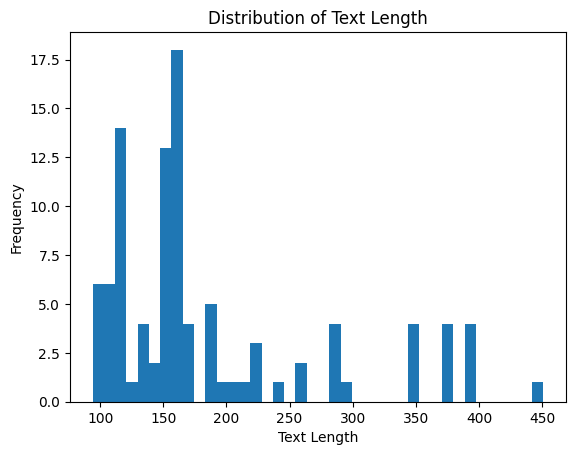

In [16]:
## Plot dist of text_length
ax = processed_data['Text_Length'].plot(kind='hist', bins=40, title='Distribution of Text Length')
ax.set_xlabel('Text Length')
ax.set_ylabel('Frequency')

In [17]:
processed_data.to_excel('processed_recipe.xlsx')

# Chunking and Embedding

In [18]:
def chunking(method: str):
    """return TextSplitter with one chunking method"""
    if method == 'RecursiveCharacterTextSplitter':
        return RecursiveCharacterTextSplitter(
            # Set a really small chunk size, just to show.
            chunk_size=1000,
            chunk_overlap=200,
            length_function=len,
        )
    elif method == 'CharacterTextSplitter':
        return CharacterTextSplitter(
            separator=" ",
            chunk_size=1000,
            chunk_overlap=200,
            length_function=len,
            is_separator_regex=False,
        )
def get_embed_model_openAI(
    embedding_model: Any = OpenAIEmbeddings,
    embedding_model_params: Optional[Dict[str, Any]] = {'openai_api_key': os.environ.get(
            'OPENAI_API_KEY'), "model": "text-embedding-3-small", 'show_progress_bar': True},
) -> Any:
    return embedding_model(**embedding_model_params)
def import_data_to_db(vectorstore, meta_data, page_content, tenant_name='Admin', index_name=None):
    # [ RecursiveCharacterTextSplitter, CharacterTextSplitter]
    text_splitter = chunking(method='RecursiveCharacterTextSplitter')
    embed_model = get_embed_model_openAI()
    doc = Document(
        metadata=meta_data,
        page_content=page_content,
    )
    documents = text_splitter.create_documents(
        [doc.page_content], metadatas=[doc.metadata]
    )
    if index_name is not None:
        db =  vectorstore.load_document_to_vectordb(
            documents = documents,
            index_name= index_name,
            text_key='text',
            embedding= embed_model, 
            tenant_name = tenant_name
            )
        
    else:
        db =  vectorstore.load_document_to_vectordb(
            documents = documents, 
            embedding= embed_model, 
            tenant_name = tenant_name
            )
    return db._index_name, db._text_key, documents

In [19]:
# init vectorstore
vectorstore = weaviatedb.WeaviateDB()
# create index 
index = f'Recipe_{uuid.uuid4().hex}' 
print(index)

Recipe_4901db92124f4ad4a22a18f5368603cb


In [20]:
vectorstore = weaviatedb.WeaviateDB()

for i, row in tqdm(processed_data.iterrows(), total=processed_data.shape[0]):
    # print(f'Imported link: {row["Url"]}')
    db = import_data_to_db(
        vectorstore=vectorstore,
        meta_data={"url": str(row['Url'])},
        page_content=row['Document'],
        tenant_name='Recipe',
        index_name=index  # latest index: Recipe_4901db92124f4ad4a22a18f5368603cb
    )

100%|██████████| 100/100 [01:17<00:00,  1.29it/s]


# Conversation

In [6]:
# Trace the conversation with Langsmith
def trace_by_langsmith(
    is_langsmith: bool=False,
    project_name: str='chatbot',
):
    if is_langsmith:
        import os
        print(f'LangChainBot: \tTracing by Langsmith')
        # Define the environment variables
        env_vars = {
            'LANGCHAIN_TRACING_V2': 'true',
            'LANGCHAIN_ENDPOINT': 'https://api.smith.langchain.com',
            'LANGCHAIN_PROJECT': project_name
        }

        for key, value in env_vars.items():
            os.environ[key] = value
# load yaml config file
def load_config(file_path):
    with open(file_path, 'r') as stream:
        try:
            return yaml.safe_load(stream)
        except yaml.YAMLError as exc:
            print(exc)
# Config for my LLM
class llm_config:
    def __init__(self, prompt_config) -> None:
        '''
        The llm_model have 2 options OpenAI and Ollama
        '''
        
        self.config = {}
        if prompt_config:
            self.prompt_config = prompt_config
            print('Loading config from file_config')
        else:
            self.prompt_config = load_config('config/prompt_config.yml')
            print('Loading config from default: config/prompt_config.yml')
        self.condense_question_prompt = self.prompt_config['prompt']['condense_question_prompt']
        self.combine_docs_prompt = self.prompt_config['prompt']['combine_docs_prompt']

    def chose_llm_model(self, llm_model='OpenAI', use_redis=True):
        if llm_model == 'OpenAI':
            LLM = OpenAI
            CHAT_MODELS = ChatOpenAI
            # CHAT_MODEL_CONFIG = ChatOpenAI(temperature=0, model="gpt-3.5-turbo-0613")
            CHAT_MODEL_CONFIG = ChatOpenAI(temperature=0)
            LLL_PARAMS = {
                "temperature": 0,
                # "model" : "gpt-3.5-turbo-0613",
            }
        elif llm_model == 'Ollama':
            LLM = Ollama
            CHAT_MODELS = ChatOllama
            CHAT_MODEL_CONFIG = ChatOllama(temperature=0, model="phi")
            LLL_PARAMS = {
                "temperature": 0,
                "model": "phi",
            }
        else:
            raise ('chose llm OpenAI or Ollama')
        self.config["knowledge_configure"] = {
            "knowledge_driver": weaviatedb.WeaviateDB}
        self.config["history_store"] = {"history_driver": redisdb.RedisDB}
        self.config["condense_question_configure"] = {"chain_core": LLMChain, "llm_core": CHAT_MODELS,
                                                      "llm_core_params": LLL_PARAMS, "prompt_core_template": self.condense_question_prompt}
        self.config["memory_configure"] = {
            "memory_core": ConversationBufferMemory}
        self.config["combine_docs_configure"] = {"stuff_chain_core": StuffDocumentsChain, "chain_core": LLMChain,
                                                 "llm_core": LLM, "llm_core_params": LLL_PARAMS, "prompt_core_template": self.combine_docs_prompt}
        if use_redis:
            self.config["stack_chain"] = {
                "chain_core": ConversationalRetrievalChain, "runnable_chain": RunnableWithMessageHistory}
        else:
            self.config["stack_chain"] = {
                "chain_core": ConversationalRetrievalChain, "runnable_chain": False}
            
        return self.config

    def chose_llm_embedding(self, llm_model='OpenAI'):
        if llm_model == 'OpenAI':
            embedding = OpenAIEmbeddings(model="text-embedding-3-small")
        elif llm_model == 'Ollama':
            embedding = OllamaEmbeddings(model="phi")
        self.config['embedding_configure'] = {'embedding': embedding}

        return self.config

    def config_db(self, index, text_key, tenant_name):
        self.config["stack_chain"]['index_db'] = index
        self.config["stack_chain"]['text_key'] = text_key
        self.config["stack_chain"]['tenant_name'] = tenant_name

        return self.config
# function that config llm model for our chatbot for each index
def start_chatbot(config_llm, index, text_key, tenant_name, debug=False):
    try:
        config = config_llm.chose_llm_embedding(
            llm_model="OpenAI")  # [OpenAI or Ollama]
        config = config_llm.chose_llm_model(
            llm_model="OpenAI", use_redis=debug)
        config = config_llm.config_db(index, text_key, tenant_name)
        # config = config_llm.langsmith(is_langsmith=True)
        chatbot = LangChainBot.bare_init(**config)
    except Exception as e:
        if debug:
            raise e  # Re-raise exception in debug mode
        else:
            chatbot = None
    return chatbot

# Start conversation
async def process_question(session_id, question, index_name, text_key, tenant, config_llm):
    trace_by_langsmith(True, project_name = "Receipe-chatbot")
    chatbot = start_chatbot(
        config_llm, index_name, text_key, tenant, debug=True)
    
    if chatbot is None:
        return {"msg": "You need to start your chatbot"}

    try:
        answer, msg = await chatbot.ask(session_id=session_id, question=question)
        return answer
    except Exception as e:
        return {"error": str(e)}

In [7]:
# config llm model
prompt_config = load_config('config/prompt_config.yml')
config_llm = llm_config(prompt_config)

Loading config from file_config


In [8]:
session_id = "111"
question = "I'm trying to make a Apple Crisp , but I'm not sure when to add the sugar. Can you guide me through the steps?"
tenant = "Recipe"
index_name = "Recipe_4901db92124f4ad4a22a18f5368603cb"
text_key = "text"
response = await process_question(session_id, question, index_name, text_key, tenant, config_llm)
print('\n The response:', response['chatbot_answer'])



LangChainBot: 	Tracing by Langsmith


Error in StdOutCallbackHandler.on_chain_start callback: AttributeError("'NoneType' object has no attribute 'get'")



> Finished chain.

 The response: To make Apple Crisp, you will need to preheat the oven to 350 degrees F (175 degrees C). Then, place sliced apples in a 9x13-inch baking dish and mix white sugar, 1 tablespoon flour, and cinnamon together; sprinkle over apples. Pour water evenly over apples. In a separate bowl, combine oats, 1 cup flour, brown sugar, baking powder, and baking soda. Add melted butter and mix with a fork until crumbly; sprinkle evenly over apple mixture. Bake in the preheated oven for about 45 minutes, until the top is golden brown and the apples are bubbling around the edges. Enjoy your delicious Apple Crisp!


In [5]:
session_id = "1"
question = "What should I do when I don't have sugar"
tenant = "Recipe"
index_name = "Recipe_4901db92124f4ad4a22a18f5368603cb"
text_key = "text"
response = await process_question(session_id, question, index_name, text_key, tenant, config_llm)
print('\n The response:', response['chatbot_answer'])



LangChainBot: 	Tracing by Langsmith


Error in StdOutCallbackHandler.on_chain_start callback: AttributeError("'NoneType' object has no attribute 'get'")



> Finished chain.

 The response: 
You can use honey, maple syrup, or coconut sugar as a substitute for white sugar in Apple Crisp.


In [6]:
session_id = "2"
question = "Suggest me recipe with apple"
tenant = "Recipe"
index_name = "Recipe_4901db92124f4ad4a22a18f5368603cb"
text_key = "text"
response = await process_question(session_id, question, index_name, text_key, tenant, config_llm)
print('\n The response:', response['chatbot_answer'])


LangChainBot: 	Tracing by Langsmith


Error in StdOutCallbackHandler.on_chain_start callback: AttributeError("'NoneType' object has no attribute 'get'")



> Finished chain.

 The response: I would suggest trying the Baked Apple Roses recipe. It's a delicious and visually appealing dessert that is sure to impress. Would you like me to provide the directions for this recipe?


In [7]:
session_id = "2"
question = "how to cook this step by step?"
tenant = "Recipe"
index_name = "Recipe_4901db92124f4ad4a22a18f5368603cb"
text_key = "text"
response = await process_question(session_id, question, index_name, text_key, tenant, config_llm)
print('\n The response:', response['chatbot_answer'])


LangChainBot: 	Tracing by Langsmith


Error in StdOutCallbackHandler.on_chain_start callback: AttributeError("'NoneType' object has no attribute 'get'")



> Finished chain.

 The response: Directions for Baked Apple Roses:
1. Preheat the oven to 400 degrees F (200 degrees C). Adjust an oven rack to the middle position. Butter two (6 to 8-ounce) ramekins and dust with white sugar.
2. Place apple slices on a microwave-safe plate, overlapping slightly if necessary. Microwave on high until slices slightly soften, about 45 seconds. Cover the plate with plastic wrap and a kitchen towel.
3. Mix together sugar and cinnamon in a small bowl.
4. Roll puff pastry sheet to less than 1/8-inch thickness. Using a pizza cutter, cut two (3x12-inch) rectangles. Reserve remaining pieces for another use.
5. Spread melted butter over dough; sprinkle with a generous amount of cinnamon sugar. Place apple slices along one long edge of dough, about 1/4 inch beyond the edge, overlapping slices slightly. Fold the bottom half of dough over apple slices to form a long "folder" of dough with rounded edges of apple slices exposed.
6. Beat together egg and water in a s